# Module 3: Analyzing Election Results and Polls

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install --upgrade us matplotlib seaborn numpy pandas > /dev/null

In [2]:
# Inline Chart Parameters
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 9)

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Python Imports
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import us
from utils import download_pres_results
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
%%javascript

IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Step 1: Download Data
- [Election Results](https://docs.google.com/spreadsheets/d/1D-edaVHTnZNhVU840EPUhz3Cgd7m39Urx7HM8Pq6Pus/edit#gid=29622862)
- Population Estimates By State
- [Polls](https://github.com/fivethirtyeight/data/tree/master/pollster-ratings)
- [Pollster Ratings](https://github.com/fivethirtyeight/data/tree/master/pollster-ratings)
- Census

## Election Results

In [4]:
pres_results_raw = download_pres_results()
pres_results_raw['d_margin'] = pres_results_raw.DEM - pres_results_raw.REP
pres_results_national = pres_results_raw[pres_results_raw.state == 'Nationwide']
pres_results_by_state = pres_results_raw[~pres_results_raw.state.isin(['Washington DC','Nationwide'])]

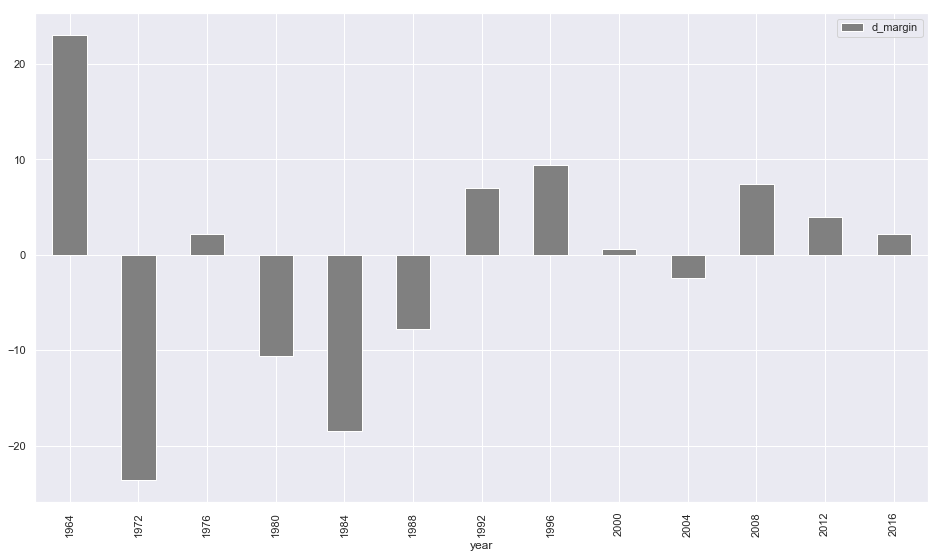

In [5]:
pres_results_national.sort_values(by='year').plot(
    x='year', y='d_margin', kind='bar', color='grey');

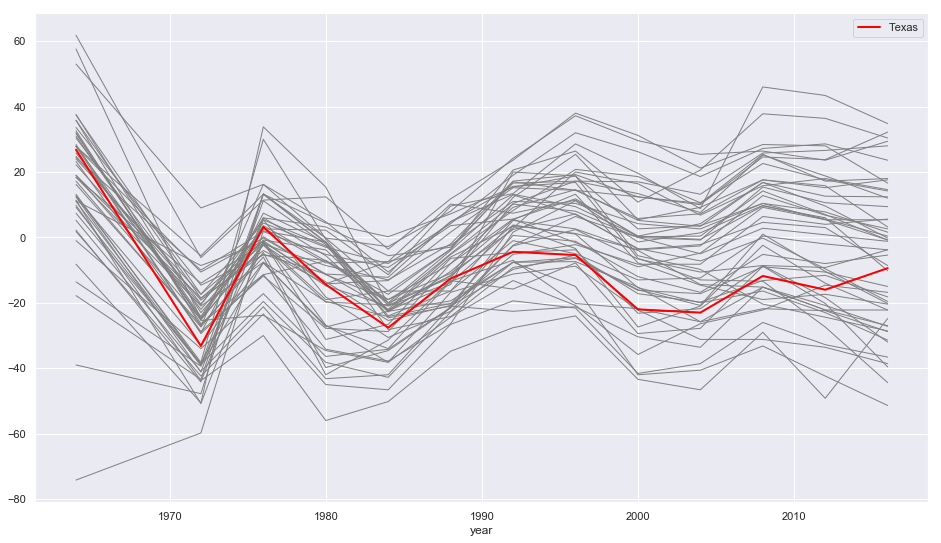

In [6]:
fig, ax = plt.subplots()
pres_results_by_state.groupby('state').plot(
    x='year', y='d_margin', c='grey', kind='line', ax=ax, legend=False, linewidth=1);
pres_results_by_state[pres_results_by_state.state=='Texas'].plot(
    x='year', y='d_margin', c='red', kind='line', ax=ax, label='Texas', linewidth=2);

### Todo
- Calculate PVI
- Plot PVI

## 2016 Presidential Election Results

1. scatterplots with trendlines of election results verus census data a-la
https://fivethirtyeight.com/features/where-trump-got-his-edge/

2. a regression with like 3 or 4 variables
    - education (some college or higher vs not)
    - gender (men vs woman)
    - race (white vs nonwhite %)
    - income

## Polling Data vs Election Results

In [7]:
polls = pd.read_csv('raw-polls.csv')
pollster_ratings = pd.read_csv('pollster-ratings.csv')
pres_polls_national = polls[(polls.type_detail=='Pres-G') & (polls.location == 'US')]
pres_polls_by_state = polls[(polls.type_detail=='Pres-G') & (polls.location != 'US')]

In [8]:
def dotplot(df, y, figsize=(16,4)):
    data = df.sort_values(by=y)
    fig, ax = plt.subplots(figsize=figsize)
    sns.stripplot(data=data,
                       x='margin_poll', y=y, orient='h', size=15,
                       jitter=False, alpha=.35, color='grey', ax=ax)
    sns.stripplot(data=data,
                       x='margin_actual', y=y, orient='h', size=15,
                       hue=data['margin_actual'].apply(lambda x: 'D' if x > 0 else 'R'),
                       palette={'D':'blue', 'R': 'red'},
                       jitter=False, alpha=.25, ax=ax)
    data = data.groupby(y).margin_poll.agg({'margin_poll': 'mean'}).sort_values(by=y).reset_index()
    sns.stripplot(data=data,
                  x='margin_poll', y=y, orient='h', size=15,
                  color='white', linewidth=1, jitter=False, ax=ax)
    plt.axvline(x=0, color='black', linewidth=0.8)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

#### nationwide popular vote: polls versus election results for each year


- plot
- look @ average error in table

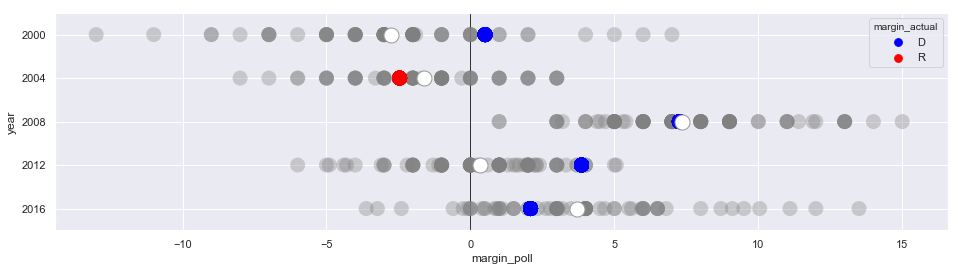

In [9]:
dotplot(pres_polls_national, y='year')

In [10]:
pres_polls_national[['year', 'bias']].groupby('year').mean()

,bias
year,
2000,-3.274062
2004,0.855000
2008,0.082857
2012,-3.513837
2016,1.618472


#### state by state polls vs popular vote for 2016

- plot
- look @ average error in table

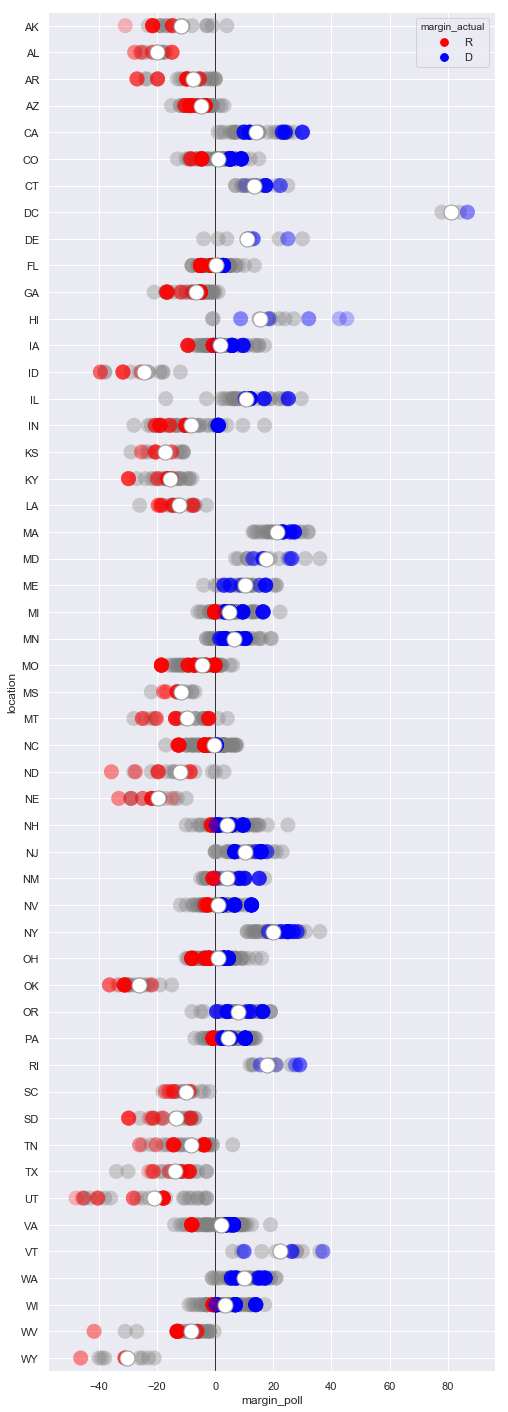

In [11]:
dotplot(pres_polls_by_state, y='location', figsize=(8,25))

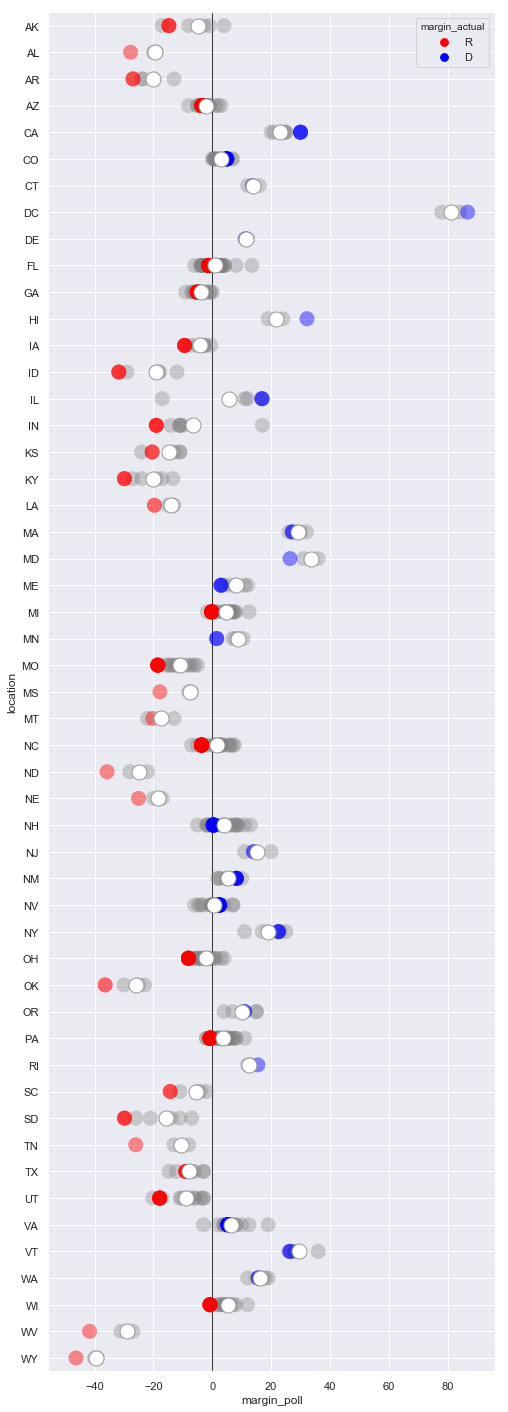

In [12]:
dotplot(pres_polls_by_state[pres_polls_by_state.year == 2016], y='location', figsize=(8,25))

#### state by state average errors for each year


- plot
- look @ average error in table

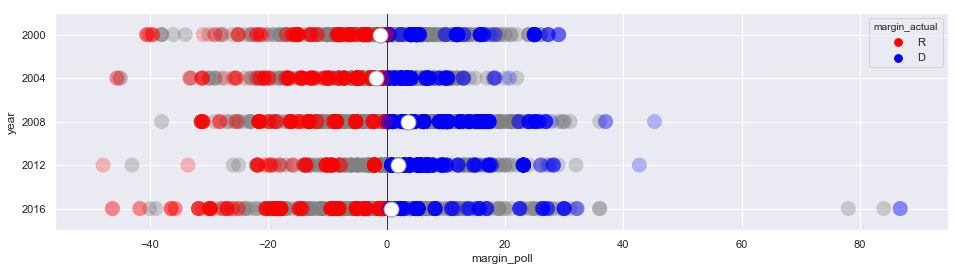

In [13]:
dotplot(pres_polls_by_state, y='year', figsize=(16,4))

In [14]:
pres_polls_by_state[['year', 'bias']].groupby('year').mean()

,bias
year,
2000,-1.966633
2004,0.989412
2008,0.089742
2012,-2.328907
2016,3.546658


#### Step 2: Polling averages and adjustment

* state by state 2016 polls
    1. plot (y axis = state - plot each poll, average of polls, and election result)
    2. plot (y axis = state - plot each *adjusted* poll, *adjusted* average of polls, and election result)
    3. plot (y axis = state - plot average, adjusted average, and election result
* do the last chart with national 2016 as well as national for all years

*Presidential Polls*

Exercise 1: Particular Polls vs Average of the Polls (2016 only, then all)

Exercise 2: Adjusted Average of the Polls (2016 only, then all)

Exercise 3: Average polling error in 2016 (compared to past years)


In [15]:
# def state_to_abbrev(state):
#     return us.states.lookup(state).abbr

# pres_results_national = pres_results_raw[pres_results_raw.state == 'Nationwide']
# pres_polls_national = polls[(polls.type_detail=='Pres-G') & (polls.location == 'US')]

In [16]:
# pres_results = pres_results_raw[~pres_results_raw.state.isin(['Washington DC','Nationwide'])]
# pres_results['state_abbrev'] = pres_results.state.apply(state_to_abbrev)
# pres_results['race'] =  pres_results.year.astype('str') + '_Pres-G_' + pres_results.state_abbrev
# pres_results.head()

## Answering Questions with Data

Lets prove or disprove some hypotheses
- As goes Ohio, so goes the nation.
- Texas is going blue
- ...come up with a few more